### Импортируем библиотеки

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns 
import matplotlib

In [2]:
#настройка, чтобы можно было просматривать все столбцы датафрейма
matplotlib.rcParams.update({'font.size': 14})
pd.options.display.max_columns = 100

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [45]:
import sys
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [44]:
from tqdm import tqdm
import statsmodels.api as sm

### Загружаем данные

In [4]:
# для дома
adres_data = 'C:/Users/Ник/OneDrive/1_Обучение/ML_проекты/IEK_test/test.xlsx'

In [5]:
df =  pd.ExcelFile(adres_data)

In [6]:
df_train = df.parse('train')

In [8]:
df_train = df_train.set_index('Date')

In [164]:
df_test = df.parse('test')

In [9]:
#  посмотрим датафрейм последние 3 строки
df_train.head(3)

,Y
Date,
2015-03-01,3022.1
2015-04-01,2474.7
2015-05-01,2405.6


In [212]:
# посмотрим размеры загруженного датафрейма
df_train.shape

(44, 1)

In [214]:
# посмотрим дополнительную информацию 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2015-03-01 to 2018-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       44 non-null     float64
dtypes: float64(1)
memory usage: 704.0 bytes


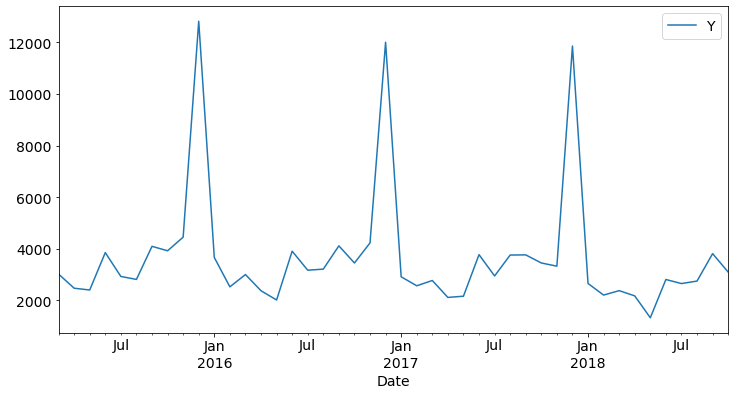

In [213]:
# визуализируем загруженные данные
df_train.plot(figsize = (12, 6))
plt.show()

### Модель SARIMA (Seasonal ARIMA) для прогнозирования временных рядов

Используем метод сезонного авторегрессионного интегрированного скользящего среднего (SARIMA) для прогнозирования временных рядов с одномерными данными, содержащими тренды и сезонность. Является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

Настройка SARIMA требует выбора гиперпараметров как для трендовых, так и для сезонных элементов ряда

#### Подбор параметров

Элементы тренда такие же, как модель ARIMA:

p: Порядок авторегрессии тренда.
d: Порядок изменения тренда.
Q: Тренд скользящей средней.

Сезонные элементы
Cезонныe элементы, (не являются частью ARIMA):

P: Сезонный порядок авторегрессии.
D: Порядок сезонных разниц.
Q: Сезонный порядок скользящих средних.
m: Количество временных шагов за один сезонный период.

In [216]:
df = df_train[['Y']].reset_index().copy()

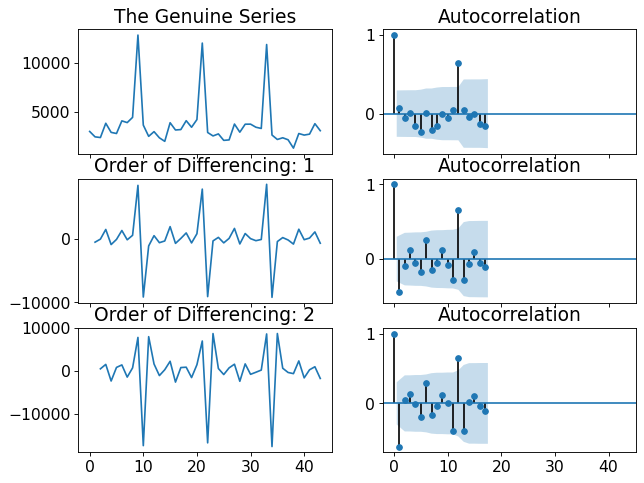

In [217]:
plt.rcParams.update({'figure.figsize' :(9,7), 'figure.dpi' : 80})

# The Genuine Series график исходного ряда с графиком автокорреляции
fig, axes = plt.subplots(3, 2, sharex = True) 
axes[0, 0].plot(df.Y); axes[0, 0].set_title('The Genuine Series') 
plot_acf(df.Y, ax = axes[0, 1]) 
 
# Order of Differencing: First  разность первого порядка с графиком автокорреляции
axes[1, 0].plot(df.Y.diff()); axes[1, 0].set_title('Order of Differencing: 1') 
plot_acf(df.Y.diff().dropna(), ax = axes[1, 1]) 
 
# Order of Differencing: Second разность второго порядка с графиком автокорреляции
axes[2, 0].plot(df.Y.diff().diff()); axes[2, 0].set_title('Order of Differencing: 2') 
plot_acf(df.Y.diff().diff().dropna(), ax = axes[2, 1]) 
 
plt.show() 


Как мы видим, временной ряд достиг стационарности с одним порядком разности
Когда мы смотрим на график автокорреляции для второго порядка дифференцирования, 
запаздывание переходит в очень отрицательную зону довольно быстро, что указывает на то,
что ряд мог быть чрезмерно разным.
Следовательно, мы предварительно зафиксируем порядок дифференцирования (p = 1), 
потому что ряд не является должным образом стационарным, или мы можем сказать, что ряд имеет слабую стационарность.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


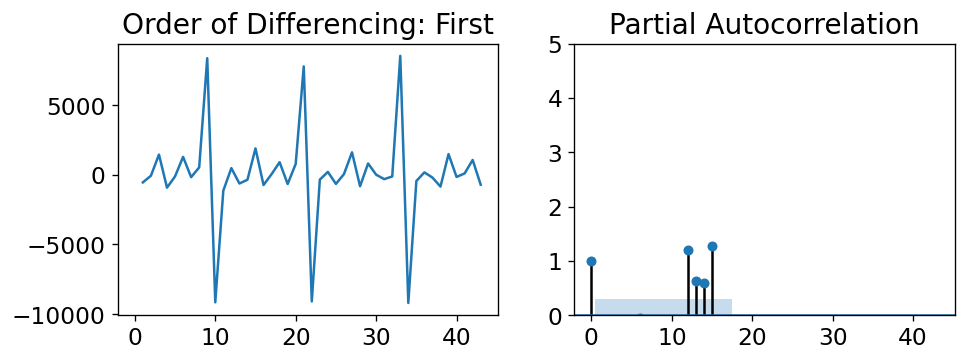

In [218]:
# Нахождение порядка авторегрессивного (AR) члена (p)
#  найдем р Количество необходимых членов AR можно найти, 
# изучив график частичной автокорреляции (PACF)
 
 
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) 

 
fig, axes = plt.subplots(1, 2, sharex = True) 
axes[0].plot(df.Y.diff()); axes[0].set_title('Order of Differencing: First') 
axes[1].set(ylim =(0,5)) 
plot_pacf(df.Y.diff().dropna(), ax = axes[1]) 
 
plt.show()

Отставание PACF 1 довольно значительно выше линии значимости. Отставание 2 также представляется значительным, полностью выдерживая переход границы значимости (синяя область). Будем консервативны и предварительно зафиксируем p как единицу.

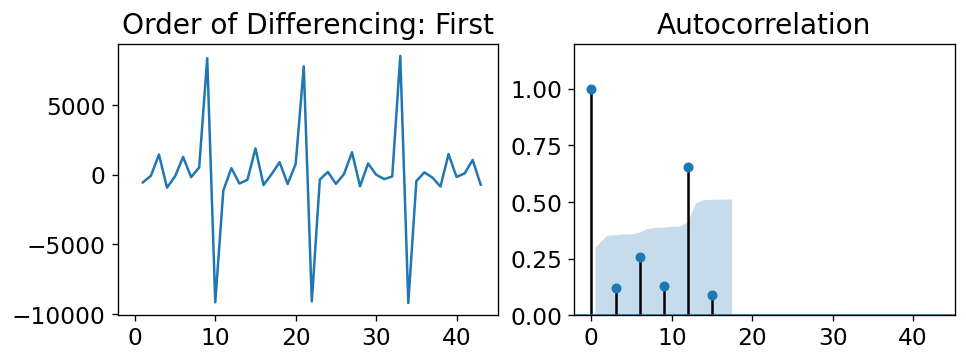

In [220]:
# Определение порядка члена скользящей средней (MA) (q)
 
plt.rcParams.update({'figure.figsize' :(9,3), 'figure.dpi' : 120}) 
 
fig, axes = plt.subplots(1, 2, sharex = True) 
axes[0].plot(df.Y.diff()); axes[0].set_title('Order of Differencing: First') 
axes[1].set(ylim =(0, 1.2)) 
plot_acf(df.Y.diff().dropna(), ax = axes[1])
 
plt.show()

Построили графики, представляющие разность первого порядка и ее автокорреляцию
Предварительно зафиксируем q равным 1.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Критерий Дики-Фуллера: p=0.000386


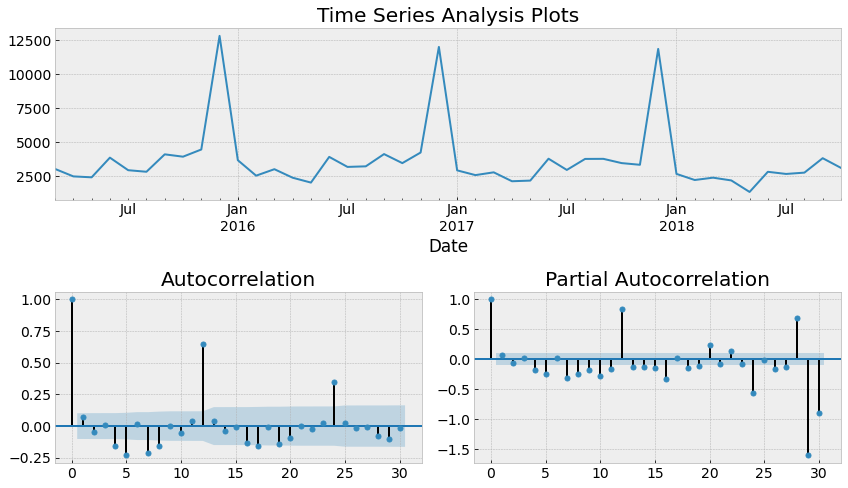

In [31]:
# отрисовка графиков
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df_train.Y, lags=30)

Критерий Дики-Фуллера < 0,05. Это означает, что ряд стационарный

In [29]:
import scipy.stats as st

In [39]:
# data['Users_box']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Критерий Дики-Фуллера: p=0.975538
Оптимальный параметр преобразования Бокса-Кокса: -0.822519


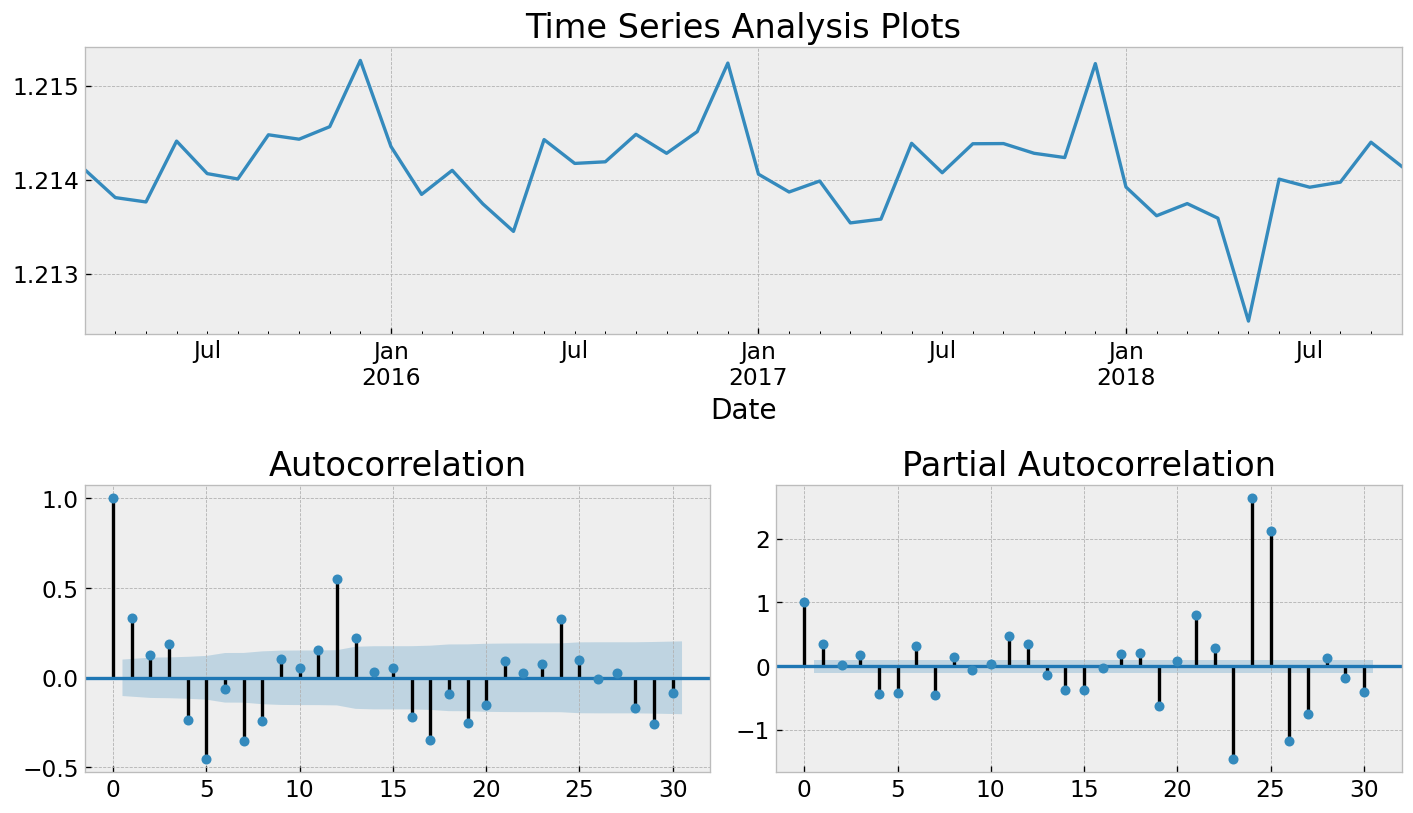

In [232]:
# ненужное действие т.к.критерий Дики-Фуллера только увеличивается
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = df_train.copy()
data['Users_box'], lmbda = st.boxcox(df_train.Y) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Построим прогноз с примерными параметрами. Сделаем 2 пристрелочных расчета

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                  Y   No. Observations:                   44
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -228.975
Date:                            Fri, 29 Apr 2022   AIC                            467.950
Time:                                    01:52:52   BIC                            475.120
Sample:                                03-01-2015   HQIC                           470.287
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1067      0.317      0.336      0.737      -0.515       0.729
ma.L1         -0.8408      0.186   

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


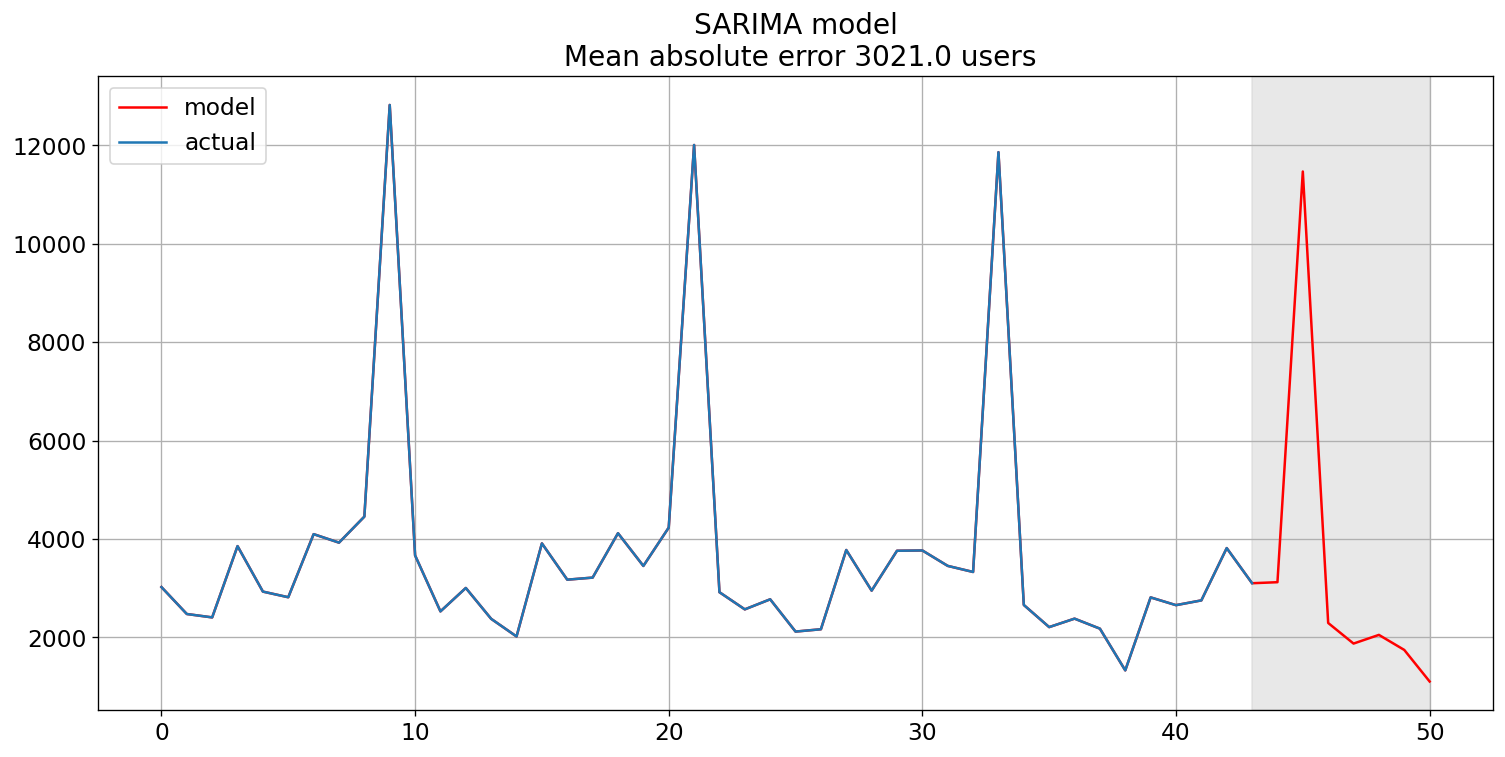

In [229]:
%%time
best_model = sm.tsa.statespace.SARIMAX(df_train.Y, order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12)).fit(disp=-1)
print(best_model.summary())

forecast_1 = best_model.predict(start = data.shape[0], end = 50)
print(forecast_1)
forecast = np.concatenate([actual,forecast_1.values])
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
actual = data.Y.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Y, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual)-1, len(forecast)-1, alpha=0.5, color='lightgrey')
plt.grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                      SARIMAX Results                                       
Dep. Variable:                                    Y   No. Observations:                   44
Model:             SARIMAX(2, 2, 2)x(1, 1, [1], 12)   Log Likelihood                -225.872
Date:                              Fri, 29 Apr 2022   AIC                            465.745
Time:                                      01:52:06   BIC                            475.553
Sample:                                  03-01-2015   HQIC                           468.883
                                       - 10-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7836      0.959     -0.817      0.414      -2.663       1.095
ar.L2         -0.43

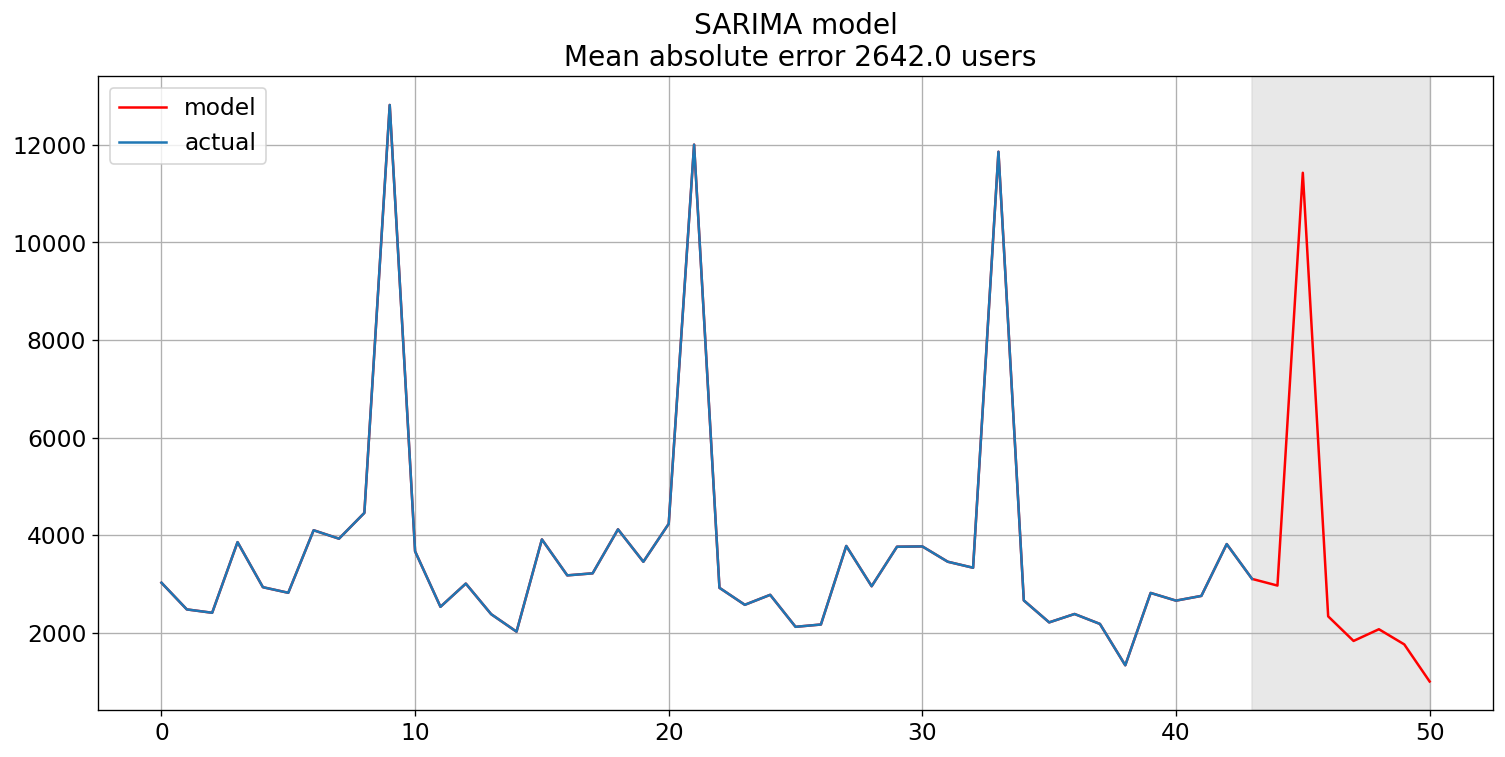

In [228]:
%%time
best_model = sm.tsa.statespace.SARIMAX(df_train.Y, order=(2, 2, 2), 
                                        seasonal_order=(1, 1, 1, 12)).fit(disp=-1)
print(best_model.summary())

forecast_1 = best_model.predict(start = data.shape[0], end = 50)
print(forecast_1)
forecast = np.concatenate([actual,forecast_1.values])

data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
# actual = data.Y.values[-400:]
actual = data.Y.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Y, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual)-1, len(forecast)-1, alpha=0.5, color='lightgrey')
plt.grid(True)

### Проведем подбор по сетке параметров

In [221]:
# зададим все вероятные параметры
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

200

In [222]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 4, 0),
 (0, 2, 4, 1),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 4, 0),
 (0, 3, 4, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 3, 0),
 (1, 0, 3, 1),
 (1, 0, 4, 0),
 (1, 0, 4, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 3, 0),
 (1, 1, 3, 1),
 (1, 1, 4, 0),
 (1, 1, 4, 1),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (1, 2, 2, 0),
 (1, 2, 2, 1),
 (1, 2, 3,

In [230]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Y, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
  0%|▍                                                                                 | 1/200 [00:00<00:23,  8.33it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▋                                                                                | 4/200 [00:01<00:55,  3.54it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seaso

       parameters         aic
10   (0, 1, 0, 0)  463.984654
12   (0, 1, 1, 0)  464.184021
11   (0, 1, 0, 1)  464.276454
112  (2, 3, 1, 0)  464.348385
111  (2, 3, 0, 1)  464.756846
Wall time: 12min 45s


#### Построим модель по наилучшим параметрам

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                                   Y   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -229.992
Date:                             Fri, 29 Apr 2022   AIC                            463.985
Time:                                     01:50:10   BIC                            466.853
Sample:                                 03-01-2015   HQIC                           464.920
                                      - 10-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8407      0.112     -7.528      0.000      -1.060      -0.622
sigma2       1.52e+05   4.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


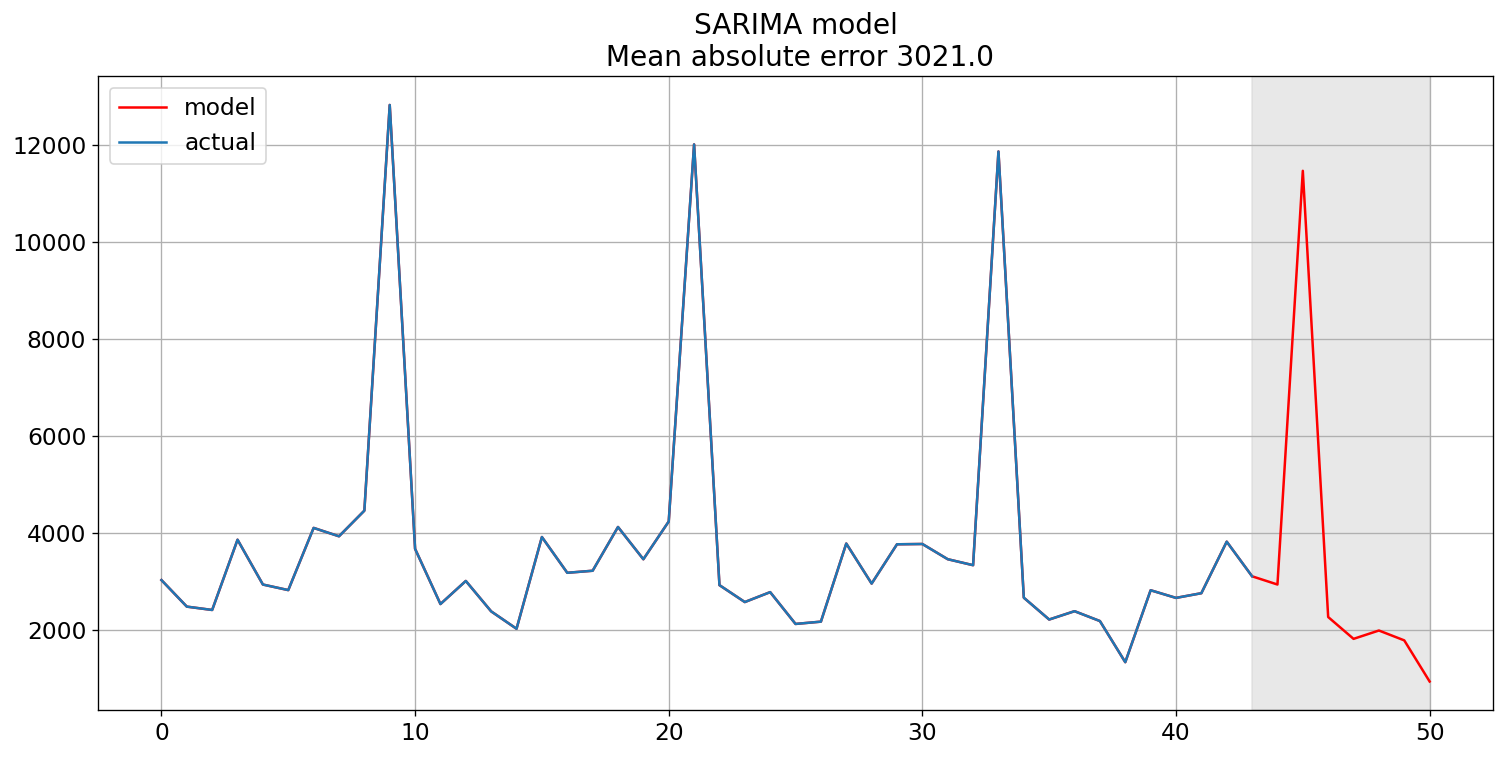

In [226]:
%%time
best_model = sm.tsa.statespace.SARIMAX(df_train.Y, order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 0, 12)).fit(disp=-1)
print(best_model.summary())

forecast_1 = best_model.predict(start = data.shape[0], end = 50)
print(forecast_1)
forecast = np.concatenate([actual,forecast_1.values])
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
actual = data.Y.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {}".format(round(mean_absolute_error(data.dropna().Y, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual)-1, len(forecast)-1, alpha=0.5, color='lightgrey')
plt.grid(True)

### Доверительный интервал

In [145]:
# импортируем библиотеку scipy.stats
import scipy.stats as st

In [224]:
forecast

array([ 3022.1       ,  2474.7       ,  2405.6       ,  3854.4       ,
        2930.        ,  2815.3       ,  4097.8       ,  3925.        ,
        4453.6       , 12819.7       ,  3666.2       ,  2527.9       ,
        3004.        ,  2376.4       ,  2018.1       ,  3909.8       ,
        3172.4       ,  3214.5       ,  4116.5       ,  3451.5       ,
        4230.7       , 12006.4       ,  2917.6       ,  2568.9       ,
        2773.5       ,  2117.5       ,  2164.8       ,  3775.4       ,
        2949.7       ,  3760.1       ,  3766.2       ,  3452.6       ,
        3328.9       , 11860.        ,  2658.4       ,  2208.5       ,
        2380.5       ,  2177.1       ,  1328.9       ,  2812.3       ,
        2654.6       ,  2751.4       ,  3814.1       ,  3100.1       ,
        2963.34155332, 11428.87191955,  2331.89312491,  1827.98635463,
        2067.83177621,  1757.18349292,   995.97645708])

In [159]:
# рассчитаем общий доверительный интервал для всей последовательности значений
#  loc (смещение) = среднее
# scale (масштаб) = стандартное отклонение
# уровень доверия 95% 
interval = st.t.interval(0.95, len(forecast)-1, loc=np.mean(forecast), scale=st.sem(forecast))
interval

(2906.300431612337, 4364.806445112371)

In [169]:
df_test = df_test.head(7)

In [175]:
df_test = df_test.set_index('Date')

In [177]:
df_test['Y'] = forecast_1

In [178]:
df_test

,Y
Date,
2018-11-01,3095.387161
2018-12-01,11481.328429
2019-01-01,2316.600766
2019-02-01,1851.265759
2019-03-01,2040.623282
2019-04-01,1748.322532
2019-05-01,1065.997428


In [162]:
forecast_1

2018-11-01     3095.387161
2018-12-01    11481.328429
2019-01-01     2316.600766
2019-02-01     1851.265759
2019-03-01     2040.623282
2019-04-01     1748.322532
2019-05-01     1065.997428
Freq: MS, dtype: float64

In [181]:
# подготовим общий датафрейм для оценки доверительного интервала
df_result = pd.concat([df_train, df_test], axis = 0)

In [184]:
def interval(df):
    '''метод расчета доверительного интервала'''
    st_interval = st.t.interval(0.95, len(df) -1, loc=np.mean(df.Y), scale=st.sem(df.Y))
    return st_interval

In [183]:
# создаём поле для дальнейшего сохранения значений доверительного интервала
df_result['interval_min'] = 0
df_result['interval_max'] = 0

In [186]:
# создадим дополнительное поле 'Month' для группировки
df_result['Month'] = pd.DatetimeIndex(df_result.index).month

In [187]:
# запускаем цикл расчета доверительного интервала
# для последовательности значени каждого месяца
for month in df_result['Month'].unique():
    df = df_result.loc[df_result['Month'] == month]
    st_interval = interval(df)
    # сохраняем значения доверительного интервала в поле 'interval'
    df_result.loc[df_result['Month'] == month, 'interval_min'] = st_interval[0]
    df_result.loc[df_result['Month'] == month, 'interval_max'] = st_interval[1]

In [188]:
df_result

,Y,interval_min,interval_max,Month
Date,,,,
2015-03-01,3022.100000,2116.318611,3171.970702,3
2015-04-01,2474.700000,1829.990833,2527.618179,4
2015-05-01,2405.600000,1086.637137,2506.721834,5
2015-06-01,3854.400000,2760.460705,4415.489295,6
2015-07-01,2930.000000,2589.192127,3264.157873,7
2015-08-01,2815.300000,2396.689515,3873.960485,8
2015-09-01,4097.800000,3655.514835,4241.785165,9
2015-10-01,3925.000000,2943.558069,4021.041931,10
2015-11-01,4453.600000,2718.048281,4836.245300,11


In [189]:
df_result_ = df_result.tail(7).copy()
df_result_

,Y,interval_min,interval_max,Month
Date,,,,
2018-11-01,3095.387161,2718.048281,4836.245300,11
2018-12-01,11481.328429,11144.749080,12938.965135,12
2019-01-01,2316.600766,1977.611838,3801.788545,1
2019-02-01,1851.265759,1758.594252,2819.688628,2
2019-03-01,2040.623282,2116.318611,3171.970702,3
2019-04-01,1748.322532,1829.990833,2527.618179,4
2019-05-01,1065.997428,1086.637137,2506.721834,5


### Выгрузка данных

In [190]:
df_result_.to_excel(r'C:/Users/Ник/OneDrive/1_Обучение/ML_проекты/IEK_test/arima_result.xlsx', index = True)

In [195]:
forecast_1

2018-11-01     2963.341553
2018-12-01    11428.871920
2019-01-01     2331.893125
2019-02-01     1827.986355
2019-03-01     2067.831776
2019-04-01     1757.183493
2019-05-01      995.976457
Freq: MS, dtype: float64

In [196]:
forecast

array([ 3022.1       ,  2474.7       ,  2405.6       ,  3854.4       ,
        2930.        ,  2815.3       ,  4097.8       ,  3925.        ,
        4453.6       , 12819.7       ,  3666.2       ,  2527.9       ,
        3004.        ,  2376.4       ,  2018.1       ,  3909.8       ,
        3172.4       ,  3214.5       ,  4116.5       ,  3451.5       ,
        4230.7       , 12006.4       ,  2917.6       ,  2568.9       ,
        2773.5       ,  2117.5       ,  2164.8       ,  3775.4       ,
        2949.7       ,  3760.1       ,  3766.2       ,  3452.6       ,
        3328.9       , 11860.        ,  2658.4       ,  2208.5       ,
        2380.5       ,  2177.1       ,  1328.9       ,  2812.3       ,
        2654.6       ,  2751.4       ,  3814.1       ,  3100.1       ,
        2963.34155332, 11428.87191955,  2331.89312491,  1827.98635463,
        2067.83177621,  1757.18349292,   995.97645708])

In [206]:
df_result['interval_min'].values

array([ 2116.31861094,  1829.99083326,  1086.63713735,  2760.46070496,
        2589.19212743,  2396.68951483,  3655.51483512,  2943.55806911,
        2718.04828073, 11144.74907962,  1977.61183812,  1758.59425196,
        2116.31861094,  1829.99083326,  1086.63713735,  2760.46070496,
        2589.19212743,  2396.68951483,  3655.51483512,  2943.55806911,
        2718.04828073, 11144.74907962,  1977.61183812,  1758.59425196,
        2116.31861094,  1829.99083326,  1086.63713735,  2760.46070496,
        2589.19212743,  2396.68951483,  3655.51483512,  2943.55806911,
        2718.04828073, 11144.74907962,  1977.61183812,  1758.59425196,
        2116.31861094,  1829.99083326,  1086.63713735,  2760.46070496,
        2589.19212743,  2396.68951483,  3655.51483512,  2943.55806911,
        2718.04828073, 11144.74907962,  1977.61183812,  1758.59425196,
        2116.31861094,  1829.99083326,  1086.63713735])

### Итоговая визуализация

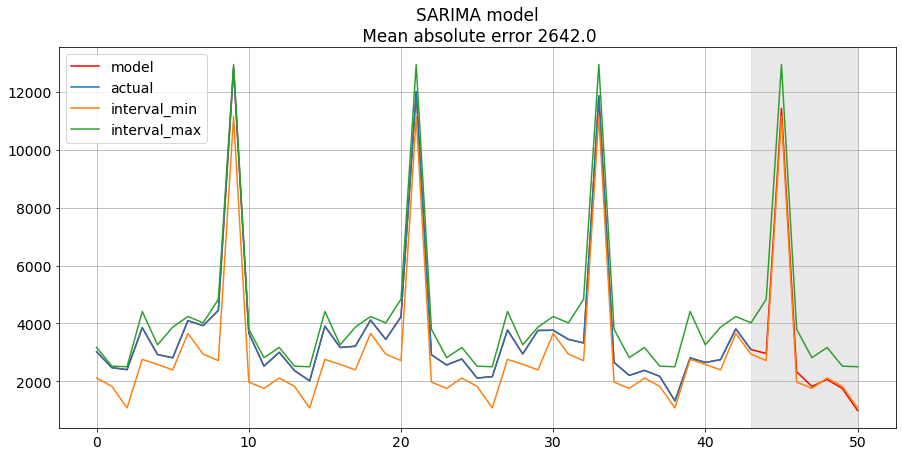

In [208]:
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {}".format(round(mean_absolute_error(data.dropna().Y, data.dropna().arima_model))))
plt.plot(actual, label="actual")


plt.plot(df_result['interval_min'].values, label="interval_min")
plt.plot(df_result['interval_max'].values, label="interval_max")
plt.legend()
plt.axvspan(len(actual)-1, len(forecast)-1, alpha=0.5, color='lightgrey')
plt.grid(True)